In [42]:
!pip install -U ydata-profiling

# Kepler Objects Of Interest Analysis

### Basic Info

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Better than just matplotlib for statistical plots

# For pandas-profiling (now called ydata-profiling)
from ydata_profiling import ProfileReport  # Not imported with 'as'

# For scikit-learn, you import specific modules/functions, not the whole package
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
# Add other sklearn imports as needed

# Additional useful libraries:
import scipy.stats as stats  # Statistical tests
import warnings

In [44]:
## Importing the dataset
kepler_df = pd.read_csv("/content/kepler_data.csv", skiprows=53)

In [45]:
kepler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In [46]:
kepler_df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


### Identification Columns

1. kepid - Identification of star around which KOI is revolving

2. kepoi_name - Idenitification given for a Kepler Point Of Interest

KOI -  A KOI is a target identified by the Kepler Project that displays at least one transit-like sequence within Kepler time-series photometry that appears to be of astrophysical origin and initially consistent with a planetary transit hypothesis.

In [47]:
kepler_df['kepid'].value_counts()[kepler_df['kepid'].value_counts() > 2]

,count
kepid,
11442793,7
11968463,7
11709124,6
10187017,6
6541920,6
...,...
9334289,3
7841925,3
10002866,3


There could be a possibility of identrtifying clusters within stars.

E.g. - Solar System around sun

**There is a possibility of creating a feature "is_multi_planet_system" and "num_candidates_in_system" here**

### Exoplanet Archive Information

**kepler_name** is an archive parameter **koi_disposition** can be a label for multi_label classification



In [48]:
kepler_df['koi_disposition'].value_counts()

,count
koi_disposition,
FALSE POSITIVE,4839
CONFIRMED,2746
CANDIDATE,1979


> **⚠️ Class Imbalance:** FALSE POSITIVE (50.6%) > CONFIRMED (28.7%) > CANDIDATE (20.7%)  
> Use `class_weight='balanced'` and evaluate with F1-score, not accuracy.

### Project Disposition Columns

> **⚠️ Data Leakage Risk - DO NOT USE as Features**
>
> **Columns:** `koi_pdisposition`, `koi_score`, `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co`, `koi_fpflag_ec`
>
> **Why exclude:** These are the **results of the vetting process**, not independent measurements. They are derived from the same analysis pipeline that produces `koi_disposition` (our target variable). Using them as features would cause severe **data leakage** - we'd be using the answer to predict the answer.
>
> **Analogy:** It's like predicting exam results using the teacher's grading notes. The flags tell us *why* something was classified as FALSE POSITIVE, but they're part of the classification process itself, not raw observational data.
>
> **Reference:** [Kepler KOI Column Definitions](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)

In [49]:
kepler_df['koi_pdisposition'].value_counts()

,count
koi_pdisposition,
FALSE POSITIVE,4847
CANDIDATE,4717


In [50]:
kepler_df['koi_score'].describe()

,koi_score
count,8054.000000
mean,0.480829
std,0.476928
min,0.000000
25%,0.000000
50%,0.334000
75%,0.998000
max,1.000000


In [51]:
# Examine the relationship between koi_pdisposition and the flag columns
print("Target variable (koi_pdisposition) - value counts:")
print(kepler_df['koi_pdisposition'].value_counts())
print("\n" + "="*60 + "\n")

# Check koi_score separately (continuous variable)
print("koi_score - descriptive statistics:")
print(kepler_df['koi_score'].describe())
print("\nkoi_score by koi_pdisposition:")
print(kepler_df.groupby('koi_pdisposition')['koi_score'].describe())
print("\n" + "="*60 + "\n")

# Check each FLAG column (categorical)
flag_columns = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

for flag_col in flag_columns:
    print(f"\n{flag_col} - unique values and counts:")
    print(kepler_df[flag_col].value_counts(dropna=False))
    print("\nCross-tabulation with koi_pdisposition:")
    crosstab = pd.crosstab(
        kepler_df['koi_pdisposition'],
        kepler_df[flag_col],
        margins=True,
        dropna=False
    )
    print(crosstab)
    print("\n" + "-"*60)

Target variable (koi_pdisposition) - value counts:
koi_pdisposition
FALSE POSITIVE    4847
CANDIDATE         4717
Name: count, dtype: int64


koi_score - descriptive statistics:
count    8054.000000
mean        0.480829
std         0.476928
min         0.000000
25%         0.000000
50%         0.334000
75%         0.998000
max         1.000000
Name: koi_score, dtype: float64

koi_score by koi_pdisposition:
                   count      mean       std  min      25%    50%  75%  max
koi_pdisposition                                                           
CANDIDATE         4102.0  0.906390  0.228884  0.0  0.96025  0.998  1.0  1.0
FALSE POSITIVE    3952.0  0.039116  0.161416  0.0  0.00000  0.000  0.0  1.0



koi_fpflag_nt - unique values and counts:
koi_fpflag_nt
0      8033
1      1530
465       1
Name: count, dtype: int64

Cross-tabulation with koi_pdisposition:
koi_fpflag_nt        0     1  465   All
koi_pdisposition                       
CANDIDATE         4715     1    1  4717
FALS

#### Why These Columns Cannot Be Used as Features

**`koi_score`**: This is literally a "planet probability score" that scientists calculated *after* they decided if something was a planet candidate or not. It's like using your final grade to predict if you passed the class - the score IS the answer, not a clue to find the answer.

**`koi_fpflag_nt` (Not Transit-like)**: This flag means "we marked this as FALSE POSITIVE because the light pattern doesn't look like a planet passing in front of a star." But wait - that's exactly what we're trying to predict! It's like using a note that says "wrong answer" to predict if an answer is wrong.

**`koi_fpflag_ss` (Stellar Eclipse)**: This flag means "we decided this is FALSE POSITIVE because it's actually two stars blocking each other, not a planet." Again, this is a conclusion from the vetting process, not raw telescope data. It's the reason WHY scientists rejected it, written down after they already made their decision.

**`koi_fpflag_co` (Centroid Offset)**: This flag means "we marked this FALSE POSITIVE because the light is coming from the wrong location - it's a nearby star, not this one." Every single time this flag is 1, it's a FALSE POSITIVE (100% correlation!). This is clearly part of the final decision, not an independent measurement.

**`koi_fpflag_ec` (Ephemeris Match)**: This flag means "we rejected this because the timing matches a known spacecraft or instrumental glitch." Like the others, this is a reason scientists wrote down AFTER deciding it was false, not telescope data we can use to make the decision.

### Transit Properties

Transit properties are the **core observational features** derived from analyzing the Kepler light curves. These parameters characterize the geometry, timing, and physical characteristics of the planetary transit events.

Transit parameters are typically best-fit parameters produced by a Mandel-Agol model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris. Some parameters are fit directly, others are derived from the best-fit parameters.

#### Categories of Transit Properties

**1. Orbital & Timing Parameters**
- `koi_period` - Orbital Period (days): Interval between consecutive transits
- `koi_time0bk` - Transit Epoch (BJD - 2,454,833.0): Timestamp of first detected transit center

**2. Transit Geometry & Observable Features**
- `koi_impact` - Impact Parameter: Sky-projected distance between planet and star centers at conjunction (normalized by stellar radius)
- `koi_duration` - Transit Duration (hours): Time from first to last contact
- `koi_depth` - Transit Depth (ppm): Fraction of stellar flux lost during transit

**3. Derived Planetary Parameters**
- `koi_prad` - Planetary Radius (Earth radii): Planet size relative to Earth
- `koi_teq` - Equilibrium Temperature (Kelvin): Estimated planet temperature
- `koi_insol` - Insolation Flux (Earth flux): Stellar energy received by planet

#### ⚠️ Important Considerations

**Circularity Risk:** Transit parameters depend on best-fit models, and physical planet parameters are derived by scaling to the star's size and temperature.  If the transit fit quality itself influences disposition decisions, using these parameters could introduce circular reasoning.

**Strategy:**
- Prioritize more directly observable parameters (`koi_period`, `koi_duration`, `koi_depth`)
- Use derived parameters (`koi_prad`, `koi_teq`, `koi_insol`) cautiously
- Monitor feature importance - if derived features dominate, investigate potential circularity

**Reference:** [Kepler Transit Properties Documentation](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html#transit)

#### Derived Features

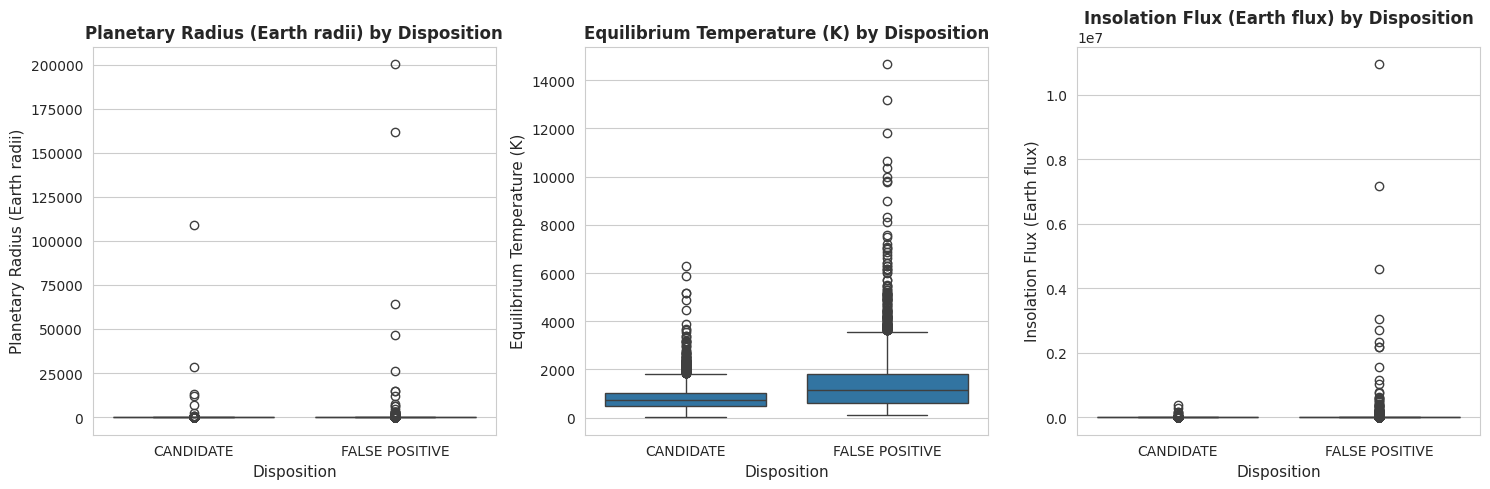

In [52]:
sns.set_style("whitegrid")

# Create box plots for the three derived parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

features = ['koi_prad', 'koi_teq', 'koi_insol']
titles = ['Planetary Radius (Earth radii)',
          'Equilibrium Temperature (K)',
          'Insolation Flux (Earth flux)']

for ax, feature, title in zip(axes, features, titles):
    sns.boxplot(data=kepler_df, x='koi_pdisposition', y=feature, ax=ax)
    ax.set_xlabel('Disposition', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} by Disposition', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [53]:
from scipy import stats
import numpy as np

# Separate the data by disposition
candidates = kepler_df[kepler_df['koi_pdisposition'] == 'CANDIDATE']
false_positives = kepler_df[kepler_df['koi_pdisposition'] == 'FALSE POSITIVE']

features = ['koi_prad', 'koi_teq', 'koi_insol']
titles = ['Planetary Radius', 'Equilibrium Temperature', 'Insolation Flux']

print("=" * 80)
print("LEAKAGE ANALYSIS: Derived Planetary Parameters")
print("=" * 80)

for feature, title in zip(features, titles):
    # Remove NaN values
    cand_values = candidates[feature].dropna()
    fp_values = false_positives[feature].dropna()

    # Mann-Whitney U test (non-parametric, handles outliers well)
    statistic, p_value = stats.mannwhitneyu(cand_values, fp_values, alternative='two-sided')

    # Cohen's d (effect size)
    mean_diff = cand_values.mean() - fp_values.mean()
    pooled_std = np.sqrt(((len(cand_values)-1)*cand_values.std()**2 +
                           (len(fp_values)-1)*fp_values.std()**2) /
                          (len(cand_values) + len(fp_values) - 2))
    cohens_d = mean_diff / pooled_std

    print(f"\n{title} ({feature}):")
    print(f"  CANDIDATE:      mean={cand_values.mean():.2f}, median={cand_values.median():.2f}")
    print(f"  FALSE POSITIVE: mean={fp_values.mean():.2f}, median={fp_values.median():.2f}")
    print(f"  Cohen's d:      {cohens_d:.3f}  ", end="")

    # Interpret Cohen's d
    if abs(cohens_d) < 0.2:
        print("(negligible)")
    elif abs(cohens_d) < 0.5:
        print("(small)")
    elif abs(cohens_d) < 0.8:
        print("(MEDIUM - concerning 🚩)")
    else:
        print("(LARGE - likely leakage 🚩🚩)")

    print(f"  Mann-Whitney p: {p_value:.2e}  ", end="")
    if p_value < 0.001:
        print("(highly significant ***)")
    elif p_value < 0.05:
        print("(significant *)")
    else:
        print("(not significant)")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("  |Cohen's d| > 0.5 = Concerning separation between groups")
print("  p < 0.05 = Statistically significant difference")
print("=" * 80)

LEAKAGE ANALYSIS: Derived Planetary Parameters

Planetary Radius (koi_prad):
  CANDIDATE:      mean=41.46, median=2.01
  FALSE POSITIVE: mean=164.63, median=8.99
  Cohen's d:      -0.040  (negligible)
  Mann-Whitney p: 5.10e-196  (highly significant ***)

Equilibrium Temperature (koi_teq):
  CANDIDATE:      mean=824.70, median=752.00
  FALSE POSITIVE: mean=1347.38, median=1153.00
  Cohen's d:      -0.641  (MEDIUM - concerning 🚩)
  Mann-Whitney p: 7.42e-162  (highly significant ***)

Insolation Flux (koi_insol):
  CANDIDATE:      mean=716.26, median=75.58
  FALSE POSITIVE: mean=14755.47, median=425.19
  Cohen's d:      -0.088  (negligible)
  Mann-Whitney p: 9.50e-166  (highly significant ***)

INTERPRETATION:
  |Cohen's d| > 0.5 = Concerning separation between groups
  p < 0.05 = Statistically significant difference


Contrary Finding: Derived Parameters Are Mostly Fine

**Initial Hypothesis:** We suspected that `koi_prad`, `koi_teq`, and `koi_insol` might be leakage features since they're derived FROM the transit signal using assumptions about planetary characteristics.

**Actual Results:**

| Feature | Cohen's d | Effect Size | Verdict |
|---------|-----------|-------------|---------|
| `koi_prad` (Planetary Radius) | -0.040 | Negligible | ✅ SAFE to use |
| `koi_teq` (Equilibrium Temperature) | -0.641 | Medium | 🚩 LEAKAGE CONCERN |
| `koi_insol` (Insolation Flux) | -0.088 | Negligible | ✅ SAFE to use |

**Conclusion:**

Contrary to our initial concern, 2 out of 3 derived parameters are actually fine for modeling. Only `koi_teq` shows problematic separation between CANDIDATE and FALSE POSITIVE groups.

The derived radius and insolation flux don't encode dispositive information strongly enough to be considered leakage, despite being calculated from the same transit data. Only equilibrium temperature shows a medium effect size (Cohen's d = -0.641) that could allow a model to "cheat" by learning the pattern "hotter objects = false positives."

**Recommendation:** Drop `koi_teq`, keep the other two derived features.

#### Measured Transit Features

In [54]:
from scipy.stats import pointbiserialr
# Features to evaluate
features = ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth']

# Encode target as binary for correlation analysis
kepler_df['target_binary'] = (kepler_df['koi_pdisposition'] == 'CANDIDATE').astype(int)

print("=" * 80)
print("FEATURE EVALUATION: Observable Transit Features")
print("=" * 80)

results = []

for feature in features:
    # Missing data
    missing_pct = kepler_df[feature].isna().sum() / len(kepler_df) * 100

    # Point-biserial correlation (numerical feature vs binary target)
    valid_data = kepler_df[[feature, 'target_binary']].dropna()
    if len(valid_data) > 0:
        corr, p_value = pointbiserialr(valid_data['target_binary'], valid_data[feature])
    else:
        corr, p_value = np.nan, np.nan

    results.append({
        'Feature': feature,
        'Missing %': missing_pct,
        'Correlation': corr,
        'P-value': p_value
    })

    print(f"\n{feature}:")
    print(f"  Missing data:  {missing_pct:.1f}%")
    print(f"  Correlation:   {corr:.3f}  ", end="")

    # Interpret correlation strength
    if abs(corr) < 0.1:
        print("(very weak)")
    elif abs(corr) < 0.3:
        print("(weak)")
    elif abs(corr) < 0.5:
        print("(moderate)")
    else:
        print("(strong)")

    print(f"  P-value:       {p_value:.2e}  ", end="")
    if p_value < 0.001:
        print("(highly significant ***)")
    elif p_value < 0.05:
        print("(significant *)")
    else:
        print("(not significant)")

# Check multicollinearity
print("\n" + "=" * 80)
print("MULTICOLLINEARITY CHECK:")
print("=" * 80)

correlation_matrix = kepler_df[features].corr()
print("\nCorrelation Matrix (|r| > 0.7 suggests multicollinearity):")
print(correlation_matrix.round(3))

# Find high correlations
high_corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((features[i], features[j], corr_val))

if high_corr_pairs:
    print("\n⚠️  High correlations found:")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("\n✅ No problematic multicollinearity detected")

print("\n" + "=" * 80)

# Clean up
kepler_df.drop('target_binary', axis=1, inplace=True)

FEATURE EVALUATION: Observable Transit Features

koi_period:
  Missing data:  0.0%
  Correlation:   0.008  (very weak)
  P-value:       4.31e-01  (not significant)

koi_time0bk:
  Missing data:  0.0%
  Correlation:   0.011  (very weak)
  P-value:       2.63e-01  (not significant)

koi_impact:
  Missing data:  3.8%
  Correlation:   -0.062  (very weak)
  P-value:       2.32e-09  (highly significant ***)

koi_duration:
  Missing data:  0.0%
  Correlation:   -0.144  (weak)
  P-value:       9.55e-46  (highly significant ***)

koi_depth:
  Missing data:  3.8%
  Correlation:   -0.276  (weak)
  P-value:       2.73e-160  (highly significant ***)

MULTICOLLINEARITY CHECK:

Correlation Matrix (|r| > 0.7 suggests multicollinearity):
              koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth
koi_period         1.000        0.096       0.005         0.037     -0.009
koi_time0bk        0.096        1.000       0.049         0.216     -0.051
koi_impact         0.005        0.049       

Observable Transit Features - Evaluation Results

We evaluated 5 directly measured transit features for predictive power, data quality, and multicollinearity.

| Feature | Missing % | Correlation | Strength | Multicollinearity |
|---------|-----------|-------------|----------|-------------------|
| `koi_period` | 0.0% | 0.008 | Very weak | ✅ None |
| `koi_time0bk` | 0.0% | 0.011 | Very weak | ✅ None |
| `koi_impact` | 3.8% | -0.062 | Very weak | ✅ None |
| `koi_duration` | 0.0% | -0.144 | Weak | ✅ None |
| `koi_depth` | 3.8% | -0.276 | Weak | ✅ None |

**Key Findings:**

- **Data Quality:** Excellent - maximum 3.8% missing values
- **Predictive Power:** `koi_depth` is the strongest predictor (r = -0.276), followed by `koi_duration` (r = -0.144). Negative correlations indicate deeper/longer transits are more associated with FALSE POSITIVES (eclipsing binaries).
- **Multicollinearity:** None detected - all inter-feature correlations < 0.7

**Decision:** Keep all 5 features. No data quality or redundancy issues, and all contribute predictive signal.



#### Final Feature Selection Summary (7 Features Total)

From the evaluated feature groups, we retain the following features for modeling:

**Observable Transit Features (5 features):**
- `koi_period` - Orbital Period
- `koi_time0bk` - Transit Epoch  
- `koi_impact` - Impact Parameter
- `koi_duration` - Transit Duration
- `koi_depth` - Transit Depth

**Derived Planetary Parameters (2 features):**
- `koi_prad` - Planetary Radius ✅
- `koi_insol` - Insolation Flux ✅
- ~~`koi_teq` - Equilibrium Temperature~~ ❌ **DROPPED** (leakage concern, Cohen's d = -0.641)

**Total: 7 features selected for modeling**

### Stellar Parameters

Stellar parameters describe the physical properties of the host star around which the planet candidate orbits. These characteristics are crucial because they affect the detectability and validation of transiting planets.

Stellar effective temperature, surface gravity, metallicity, radius, mass, and age should comprise a consistent set, with associated error estimates representing 1-σ uncertainties.

**Available Stellar Features:**

1. **`koi_steff`** - Stellar Effective Temperature (Kelvin)
   - The photospheric temperature of the star
   - Indicates star type (hot blue stars vs cool red stars)
   - Affects planet equilibrium temperature calculations

2. **`koi_slogg`** - Stellar Surface Gravity (log₁₀(cm s⁻²))
   - Base-10 logarithm of acceleration due to gravity at star's surface
   - Helps distinguish main sequence stars from giants
   - Related to stellar mass and radius

3. **`koi_srad`** - Stellar Radius (solar radii)
   - The photospheric radius of the star (relative to our Sun)
   - Directly used to scale planetary radius from transit depth
   - Larger stars = larger planets for same transit depth

**Missing Values:** All three stellar parameters have 363 missing values (9201/9564 available). These missing values may indicate stars with insufficient characterization data.

**Physical Relationships:**
- These parameters are interdependent through stellar evolution models
- Stellar radius affects derived planetary radius (`koi_prad`)
- Stellar temperature affects planetary equilibrium temperature (`koi_teq`)

**Analysis Goals:**
- Distribution of stellar types in the dataset
- Correlation between stellar properties and disposition
- Whether certain star types are more likely to host false positives

**Reference:** [Kepler Stellar Parameters Documentation](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html#stellar)

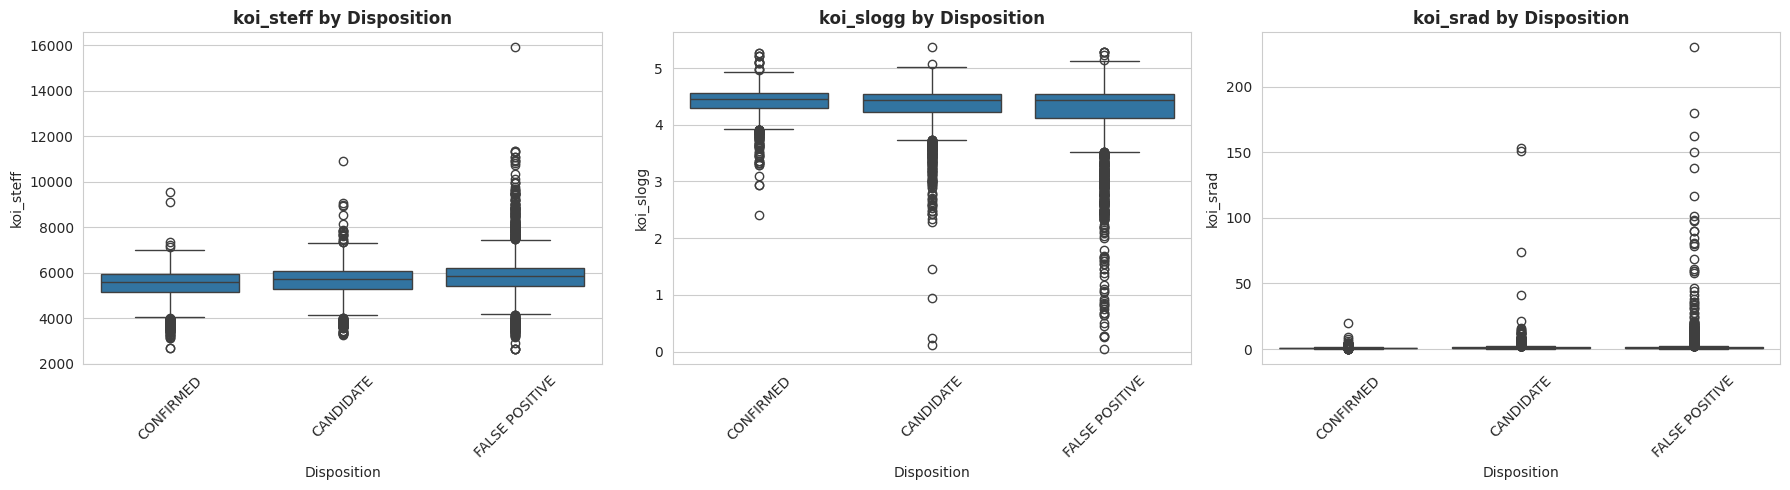

In [55]:
stellar_features = ['koi_steff', 'koi_slogg', 'koi_srad']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(stellar_features):
    sns.boxplot(data=kepler_df, x='koi_disposition', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature} by Disposition', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Disposition')
    axes[idx].set_ylabel(feature)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Binary dataset size: 9564 rows
  CANDIDATE: 4717
  FALSE POSITIVE: 4847



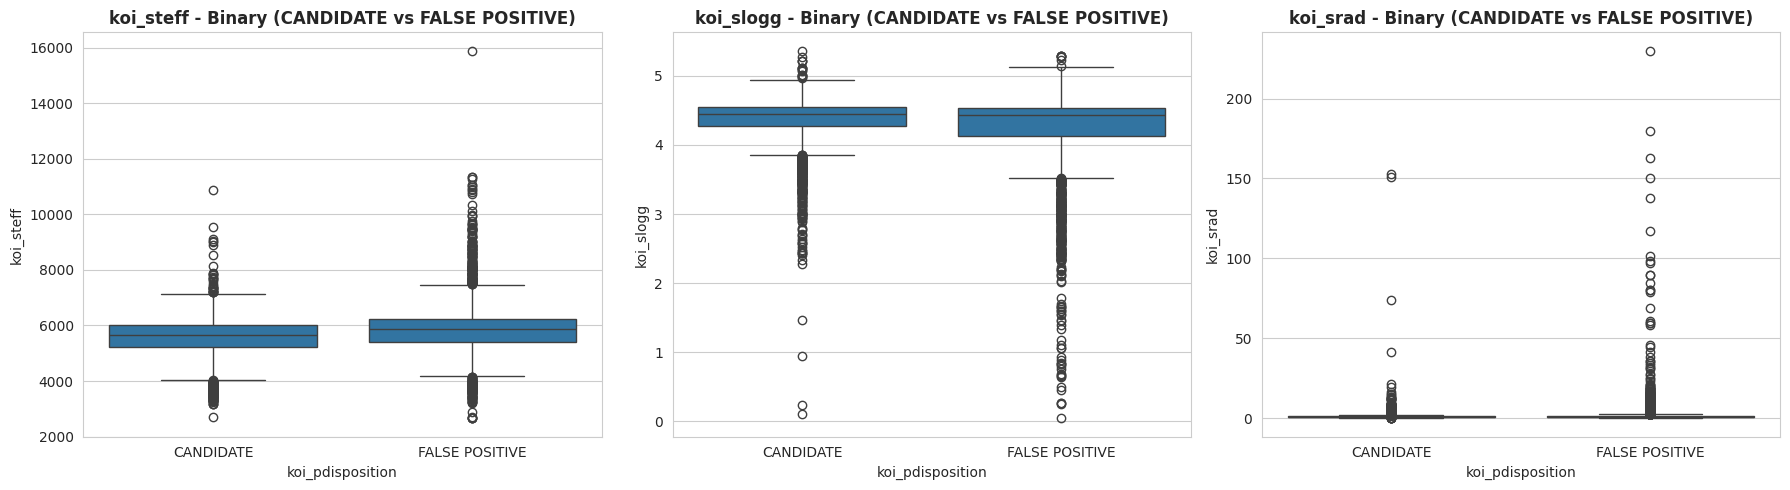

In [56]:
# Use koi_pdisposition for binary classification
binary_df = kepler_df[kepler_df['koi_pdisposition'].isin(['CANDIDATE', 'FALSE POSITIVE'])].copy()

print(f"Binary dataset size: {len(binary_df)} rows")
print(f"  CANDIDATE: {len(binary_df[binary_df['koi_pdisposition'] == 'CANDIDATE'])}")
print(f"  FALSE POSITIVE: {len(binary_df[binary_df['koi_pdisposition'] == 'FALSE POSITIVE'])}")
print()

# Box plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(stellar_features):
    plot_data = binary_df[[feature, 'koi_pdisposition']].dropna()

    sns.boxplot(data=plot_data, x='koi_pdisposition', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature} - Binary (CANDIDATE vs FALSE POSITIVE)',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('koi_pdisposition')
    axes[idx].set_ylabel(feature)

plt.tight_layout()
plt.show()

### Engineering a Feature and Testing It

In [57]:
# Cell: Feature Engineering - Multi-Planet System Indicator

# Count number of KOIs per star (kepid)
koi_counts = kepler_df.groupby('kepid').size().reset_index(name='num_kois_per_star')

# Merge back to main dataframe
kepler_df = kepler_df.merge(koi_counts, on='kepid', how='left')

# Create binary indicator for multi-planet systems (3+ candidates)
kepler_df['is_multi_planet_system'] = (kepler_df['num_kois_per_star'] >= 3).astype(int)

# Summary statistics
print("Multi-Planet System Feature Summary:")
print("="*50)
print(f"\nTotal unique stars: {kepler_df['kepid'].nunique()}")
print(f"Stars with 3+ candidates: {(koi_counts['num_kois_per_star'] >= 3).sum()}")
print(f"\nDistribution of candidates per star:")
print(kepler_df['num_kois_per_star'].value_counts().sort_index())
print(f"\nMulti-planet system flag distribution:")
print(kepler_df['is_multi_planet_system'].value_counts())

Multi-Planet System Feature Summary:

Total unique stars: 8214
Stars with 3+ candidates: 277

Distribution of candidates per star:
num_kois_per_star
1    7276
2    1322
3     537
4     272
5     125
6      18
7      14
Name: count, dtype: int64

Multi-planet system flag distribution:
is_multi_planet_system
0    8598
1     966
Name: count, dtype: int64



Multi-Planet System by Disposition:

Percentage in multi-planet systems by class:
is_multi_planet_system      0      1
koi_disposition                     
CANDIDATE               92.42   7.58
CONFIRMED               72.18  27.82
FALSE POSITIVE          98.93   1.07


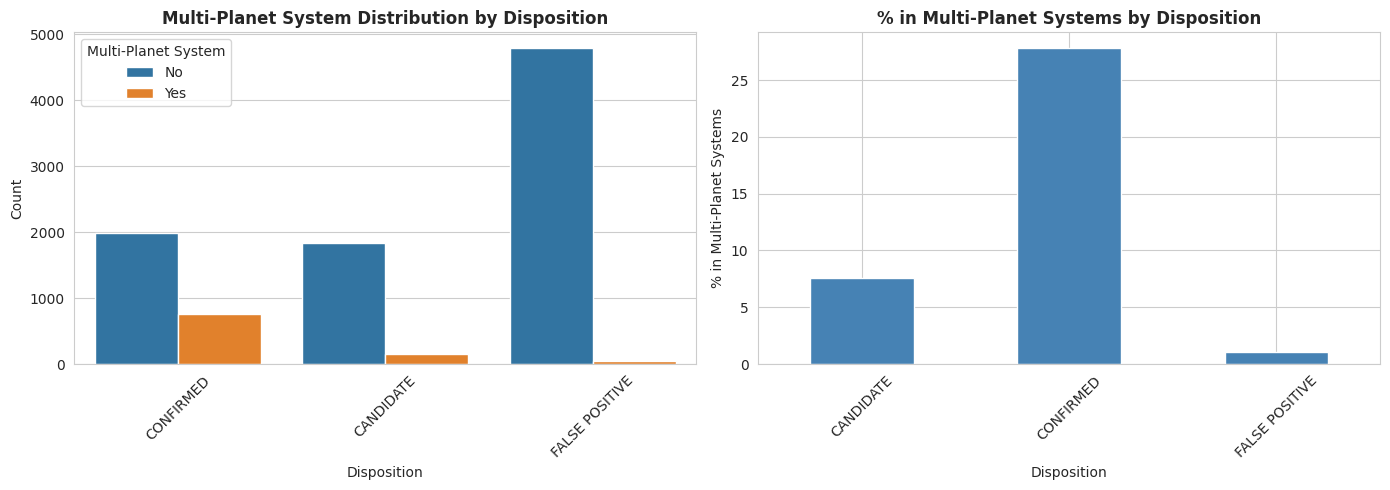

In [58]:
# Cell: Analyze Multi-Planet Feature by Disposition

print("\nMulti-Planet System by Disposition:")
print("="*50)
crosstab = pd.crosstab(
    kepler_df['koi_disposition'],
    kepler_df['is_multi_planet_system'],
    normalize='index'
) * 100

print("\nPercentage in multi-planet systems by class:")
print(crosstab.round(2))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=kepler_df, x='koi_disposition', hue='is_multi_planet_system', ax=axes[0])
axes[0].set_title('Multi-Planet System Distribution by Disposition', fontweight='bold')
axes[0].set_xlabel('Disposition')
axes[0].set_ylabel('Count')
axes[0].legend(title='Multi-Planet System', labels=['No', 'Yes'])
axes[0].tick_params(axis='x', rotation=45)

# Proportion plot
disposition_groups = kepler_df.groupby('koi_disposition')['is_multi_planet_system'].mean() * 100
disposition_groups.plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('% in Multi-Planet Systems by Disposition', fontweight='bold')
axes[1].set_xlabel('Disposition')
axes[1].set_ylabel('% in Multi-Planet Systems')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [59]:
# Cell: Statistical Test - Decision Power

from scipy.stats import chi2_contingency

# Chi-square test for independence
contingency_table = pd.crosstab(
    kepler_df['koi_disposition'],
    kepler_df['is_multi_planet_system']
)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test for Independence:")
print("="*50)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.001:
    print("\n✓ STRONG PREDICTIVE POWER (p < 0.001)")
    print("Multi-planet system status is significantly associated with disposition!")
elif p_value < 0.05:
    print("\n✓ Moderate predictive power (p < 0.05)")
else:
    print("\n✗ WEAK/NO predictive power (p >= 0.05)")

print("\n" + "="*50)
print("DECISION: Keep 'is_multi_planet_system' as feature?" )
print("Yes" if p_value < 0.05 else "No - drop this feature")


Chi-Square Test for Independence:
Chi-square statistic: 1397.7754
p-value: 2.9987e-304
Degrees of freedom: 2

✓ STRONG PREDICTIVE POWER (p < 0.001)
Multi-planet system status is significantly associated with disposition!

DECISION: Keep 'is_multi_planet_system' as feature?
Yes


Feature Engineering: Multi-Planet System Indicator

Created `is_multi_planet_system` binary feature based on `kepid` grouping (1 if star has 3+ planet candidates, 0 otherwise).

**Key Finding - Strong Discriminative Power:**

Percentage of KOIs in multi-planet systems by disposition:
- **CONFIRMED: 27.82%** - Real planets often exist in systems
- **CANDIDATE: 7.58%** - Intermediate
- **FALSE POSITIVE: 1.07%** - Almost always isolated detections

**Physical Interpretation:** Real planets form in multi-planet systems (like our solar system), while false positives (instrumental artifacts, background eclipsing binaries) are typically isolated random events. A KOI in a multi-planet system is ~26x more likely to be confirmed than a false positive.

**Decision: ✓ KEEP as feature** - This captures genuine astrophysical signal about planetary system architecture.

**Updated feature count: 11 features** (10 original + multi-planet indicator)

## Final Feature Set for Modeling*

After comprehensive EDA and feature analysis, the following 11 features have been selected for exoplanet classification:

**Observable Transit Features (5 features):**
- `koi_period` - Orbital Period (days)
- `koi_time0bk` - Transit Epoch (BJD - 2,454,833.0)
- `koi_impact` - Impact Parameter
- `koi_duration` - Transit Duration (hours)
- `koi_depth` - Transit Depth (ppm)

**Derived Planetary Parameters (2 features):**
- `koi_prad` - Planetary Radius (Earth radii)
- `koi_insol` - Insolation Flux (Earth flux)

**Stellar Parameters (3 features):**
- `koi_steff` - Stellar Effective Temperature (Kelvin)
- `koi_slogg` - Stellar Surface Gravity (log₁₀(cm s⁻²))
- `koi_srad` - Stellar Radius (solar radii)

**Engineered Features (1 feature):**
- `is_multi_planet_system` - Binary indicator for stars with 3+ planet candidates (strong discriminative power: CONFIRMED 27.82% vs FALSE POSITIVE 1.07%)

**Target Variable:**
- `koi_disposition` - 3-class classification (CONFIRMED, FALSE POSITIVE, CANDIDATE)

**Features Excluded:**
- All error columns (_err1, _err2) - measurement uncertainty, not physical properties
- Disposition-related columns (koi_pdisposition, koi_score, koi_fpflag_*) - data leakage risk
- Quality metrics (koi_model_snr, koi_tce_plnt_num, koi_tce_delivname) - circular reasoning
- Identifiers (kepid, kepoi_name, kepler_name, ra, dec, koi_kepmag) - not predictive
- koi_teq - dropped due to leakage concerns (Cohen's d = -0.641)
- Empty columns (koi_teq_err1, koi_teq_err2) - 0 non-null values

**Total: 11 features selected from 49 original columns**

**Missing Values:** 363 rows have missing values in transit/stellar parameters (9201/9564 complete cases)

In [62]:
# Final feature list for modeling
features = [
    # Observable Transit Features
    'koi_period',
    'koi_time0bk',
    'koi_impact',
    'koi_duration',
    'koi_depth',

    # Derived Planetary Parameters
    'koi_prad',
    'koi_insol',

    # Stellar Parameters
    'koi_steff',
    'koi_slogg',
    'koi_srad',

    # Engineered Features
    'is_multi_planet_system'
]

# Target variable
target = 'koi_pdisposition'

print(f"Total features: {len(features)}")
print(f"Target variable: {target}")

Total features: 11
Target variable: koi_pdisposition


In [63]:
# Create modeling dataframe with selected features and target
modeling_df = kepler_df[features + [target]].copy()

print(f"Modeling dataset shape: {modeling_df.shape}")
print(f"Features: {len(features)}")
print(f"Samples: {len(modeling_df)}")
print(f"\nMissing values per column:")
print(modeling_df.isnull().sum())
print(f"\nTarget distribution:")
print(modeling_df[target].value_counts())

Modeling dataset shape: (9564, 12)
Features: 11
Samples: 9564

Missing values per column:
koi_period                  0
koi_time0bk                 0
koi_impact                363
koi_duration                0
koi_depth                 363
koi_prad                  363
koi_insol                 321
koi_steff                 363
koi_slogg                 363
koi_srad                  363
is_multi_planet_system      0
koi_pdisposition            0
dtype: int64

Target distribution:
koi_pdisposition
FALSE POSITIVE    4847
CANDIDATE         4717
Name: count, dtype: int64


In [64]:
# Drop rows with any missing values
modeling_df_clean = modeling_df.dropna()

print(f"Original shape: {modeling_df.shape}")
print(f"After dropping nulls: {modeling_df_clean.shape}")
print(f"Rows dropped: {len(modeling_df) - len(modeling_df_clean)}")
print(f"\nPercentage of data retained: {len(modeling_df_clean)/len(modeling_df)*100:.2f}%")
print(f"\nTarget distribution after dropping nulls:")
print(modeling_df_clean[target].value_counts())
print(f"\nClass percentages:")
print(modeling_df_clean[target].value_counts(normalize=True) * 100)

Original shape: (9564, 12)
After dropping nulls: (9201, 12)
Rows dropped: 363

Percentage of data retained: 96.20%

Target distribution after dropping nulls:
koi_pdisposition
CANDIDATE         4612
FALSE POSITIVE    4589
Name: count, dtype: int64

Class percentages:
koi_pdisposition
CANDIDATE         50.124986
FALSE POSITIVE    49.875014
Name: proportion, dtype: float64


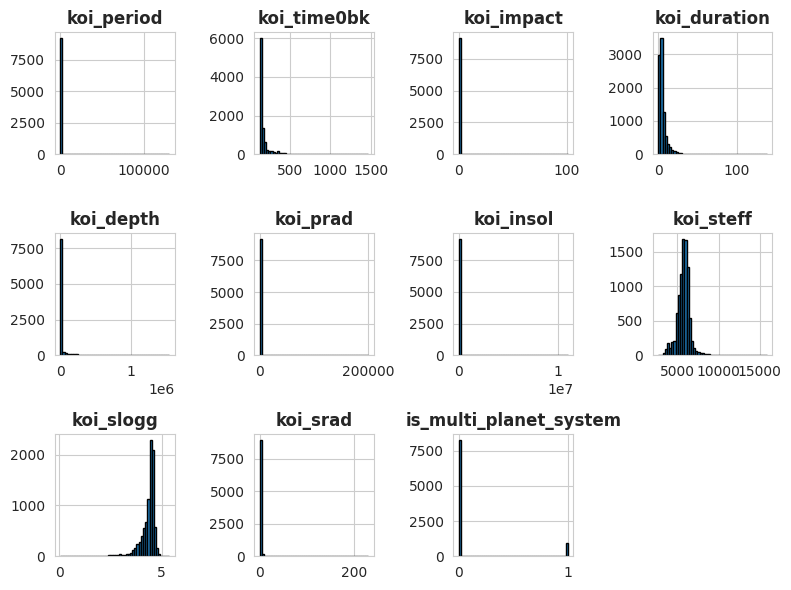


Feature scales (min, max, mean, std):
                                min           max          mean            std
koi_period                 0.241843  1.299958e+05     74.307951    1360.538847
koi_time0bk              120.515914  1.472522e+03    165.461519      67.315287
koi_impact                 0.000000  1.008060e+02      0.735105       3.348832
koi_duration               0.052000  1.385400e+02      5.654692       6.499703
koi_depth                  0.000000  1.541400e+06  23791.335898   82242.683149
koi_prad                   0.080000  2.003460e+05    102.891778    3077.639126
koi_insol                  0.000000  1.094755e+07   7716.611186  159545.537301
koi_steff               2661.000000  1.589600e+04   5706.823280     796.857947
koi_slogg                  0.047000  5.364000e+00      4.310157       0.432606
koi_srad                   0.109000  2.299080e+02      1.728712       6.127185
is_multi_planet_system     0.000000  1.000000e+00      0.102815       0.303733


In [67]:
fig, axes = plt.subplots(3, 4, figsize= (8, 6))
axes = axes.flatten()

for idx, feature in enumerate(features):
    modeling_df_clean[feature].hist(bins=50, ax=axes[idx], edgecolor='black')
    axes[idx].set_title(feature, fontweight='bold')
    axes[idx].set_xlabel('')

# Remove empty subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Check feature scales
print("\nFeature scales (min, max, mean, std):")
print("="*60)
print(modeling_df_clean[features].describe().loc[['min', 'max', 'mean', 'std']].T)

Applying Log Transformation

In [68]:
# Features needing log transformation (extreme right skew)
log_features = [
    'koi_period',      # Extreme skew, ranges 0-100k+
    'koi_depth',       # Extreme skew, mostly near 0
    'koi_prad',        # Extreme skew, ranges 0-200k+
    'koi_insol'        # Extreme skew, ranges 0-10M+
]

# Features that look okay as-is (more normal-ish)
no_transform_needed = [
    'koi_time0bk',     # Already fairly concentrated
    'koi_impact',      # Bounded 0-100, reasonable distribution
    'koi_duration',    # Already concentrated at low values
    'koi_steff',       # Nice bell curve, near-normal
    'koi_slogg',       # Near-normal distribution
    'koi_srad',        # Concentrated with few outliers
    'is_multi_planet_system'  # Binary categorical (0/1), don't transform
]

In [69]:
modeling_df_log = modeling_df_clean.copy()

for feature in log_features:
    modeling_df_log[feature] = np.log1p(modeling_df_log[feature])

print(f"Log-transformed features: {log_features}")
print(f"Shape: {modeling_df_log.shape}")

Log-transformed features: ['koi_period', 'koi_depth', 'koi_prad', 'koi_insol']
Shape: (9201, 12)


In [71]:
# Cell: Save datasets before modeling

# Save the cleaned dataset with original features
modeling_df_clean.to_csv('kepler_modeling_clean.csv', index=False)
print("✓ Saved: kepler_modeling_clean.csv")
print(f"  Shape: {modeling_df_clean.shape}")
print(f"  Features: raw/original scale")

# Save the log-transformed dataset
modeling_df_log.to_csv('kepler_modeling_log.csv', index=False)
print("\n✓ Saved: kepler_modeling_log.csv")
print(f"  Shape: {modeling_df_log.shape}")
print(f"  Features: {log_features} are log-transformed")

print("\n" + "="*60)
print("DATASETS READY FOR MODELING")
print("="*60)
print(f"Total samples: {len(modeling_df_clean)}")
print(f"Total features: {len(features)}")
print(f"Target: {target} (binary: CANDIDATE vs FALSE POSITIVE)")
print(f"Class balance: ~50/50")
print("\nUse 'kepler_modeling_clean.csv' for tree-based models")
print("Use 'kepler_modeling_log.csv' for linear models (optional comparison)")

✓ Saved: kepler_modeling_clean.csv
  Shape: (9201, 12)
  Features: raw/original scale

✓ Saved: kepler_modeling_log.csv
  Shape: (9201, 12)
  Features: ['koi_period', 'koi_depth', 'koi_prad', 'koi_insol'] are log-transformed

DATASETS READY FOR MODELING
Total samples: 9201
Total features: 11
Target: koi_pdisposition (binary: CANDIDATE vs FALSE POSITIVE)
Class balance: ~50/50

Use 'kepler_modeling_clean.csv' for tree-based models
Use 'kepler_modeling_log.csv' for linear models (optional comparison)


## Modeling with ML


In [72]:
modeling_df_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9201 entries, 0 to 9563
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   koi_period              9201 non-null   float64
 1   koi_time0bk             9201 non-null   float64
 2   koi_impact              9201 non-null   float64
 3   koi_duration            9201 non-null   float64
 4   koi_depth               9201 non-null   float64
 5   koi_prad                9201 non-null   float64
 6   koi_insol               9201 non-null   float64
 7   koi_steff               9201 non-null   float64
 8   koi_slogg               9201 non-null   float64
 9   koi_srad                9201 non-null   float64
 10  is_multi_planet_system  9201 non-null   int64  
 11  koi_pdisposition        9201 non-null   object 
dtypes: float64(10), int64(1), object(1)
memory usage: 934.5+ KB


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Separate features and target
X = modeling_df_log.drop('koi_pdisposition', axis=1)
y = modeling_df_log['koi_pdisposition']

# Encode target: CANDIDATE=1, FALSE POSITIVE=0
y = (y == 'CANDIDATE').astype(int)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Dataset prepared successfully!")
print(f"Total features: {X.shape[1]}")
print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")
print(f"Class distribution (train): {y_train.value_counts().to_dict()}")
print(f"Class distribution (test): {y_test.value_counts().to_dict()}")

Dataset prepared successfully!
Total features: 11
Training set: 7360 samples
Test set: 1841 samples
Class distribution (train): {1: 3689, 0: 3671}
Class distribution (test): {1: 923, 0: 918}


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

results = []

for model_name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

# Summary table
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("MODEL COMPARISON:")
print("="*70)
print(results_df.to_string(index=False))


Logistic Regression:
  Accuracy:  0.8034
  Precision: 0.7705
  Recall:    0.8657
  F1-Score:  0.8153
  ROC-AUC:   0.8730

Random Forest:
  Accuracy:  0.8501
  Precision: 0.8338
  Recall:    0.8754
  F1-Score:  0.8541
  ROC-AUC:   0.9289

SVM:
  Accuracy:  0.8528
  Precision: 0.8313
  Recall:    0.8862
  F1-Score:  0.8579
  ROC-AUC:   0.9191

MODEL COMPARISON:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.803368   0.770492 0.865655  0.815306 0.873049
      Random Forest  0.850081   0.833849 0.875406  0.854123 0.928922
                SVM  0.852797   0.831301 0.886241  0.857892 0.919065
